# Imports and configs

In [1]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import json
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e11/train.csv'
    test_path = '/kaggle/input/playground-series-s4e11/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e11/sample_submission.csv'
    
    original_data_path = '/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv'
    
    target = 'Depression'
    n_folds = 5
    seed = 42

# Data loading and preprocessing

In [3]:
_train = pd.read_csv(CFG.train_path, index_col='id')
_test = pd.read_csv(CFG.test_path, index_col='id')

- Similar to previous months' playground competitions, the dataset this time is also imbalanced, with the majority consisting of negative cases for depression. The imbalance ratio is not very high, so we won't do any upsampling or downsampling.

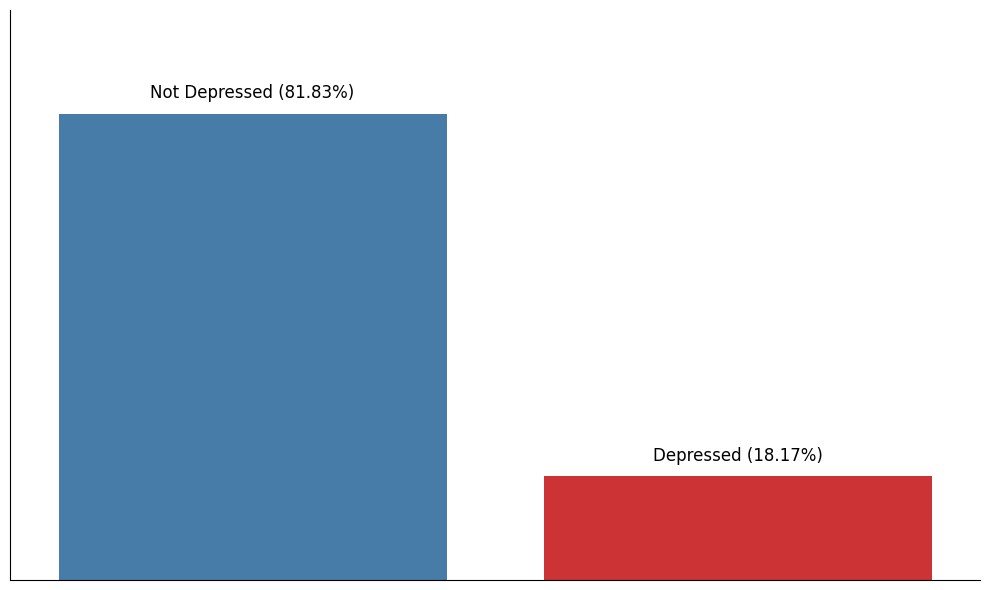

In [4]:
depression_counts = _train.Depression.value_counts(normalize=True).reset_index()
depression_counts.columns = ['Depression', 'Proportion']
palette = {0: sns.color_palette("Set1")[1], 1: sns.color_palette("Set1")[0]}
class_mapping = {0: 'Not Depressed', 1: 'Depressed'}

plt.figure(figsize=(10, 6))
sns.barplot(x='Depression', y='Proportion', data=depression_counts, palette=palette)

plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(0, 1)

for index, row in depression_counts.iterrows():
    plt.text(row.name, row.Proportion + 0.02, f'{class_mapping[row.name]} ({row.Proportion:.2%})', ha='center', va='bottom', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

- There are several categorical columns in the dataset, and some contain missing values. We will leave the missing values as they are, as most of the models we'll be using can handle missing values on their own.
- Some categorical columns have high cardinality, while others have only two unique values.

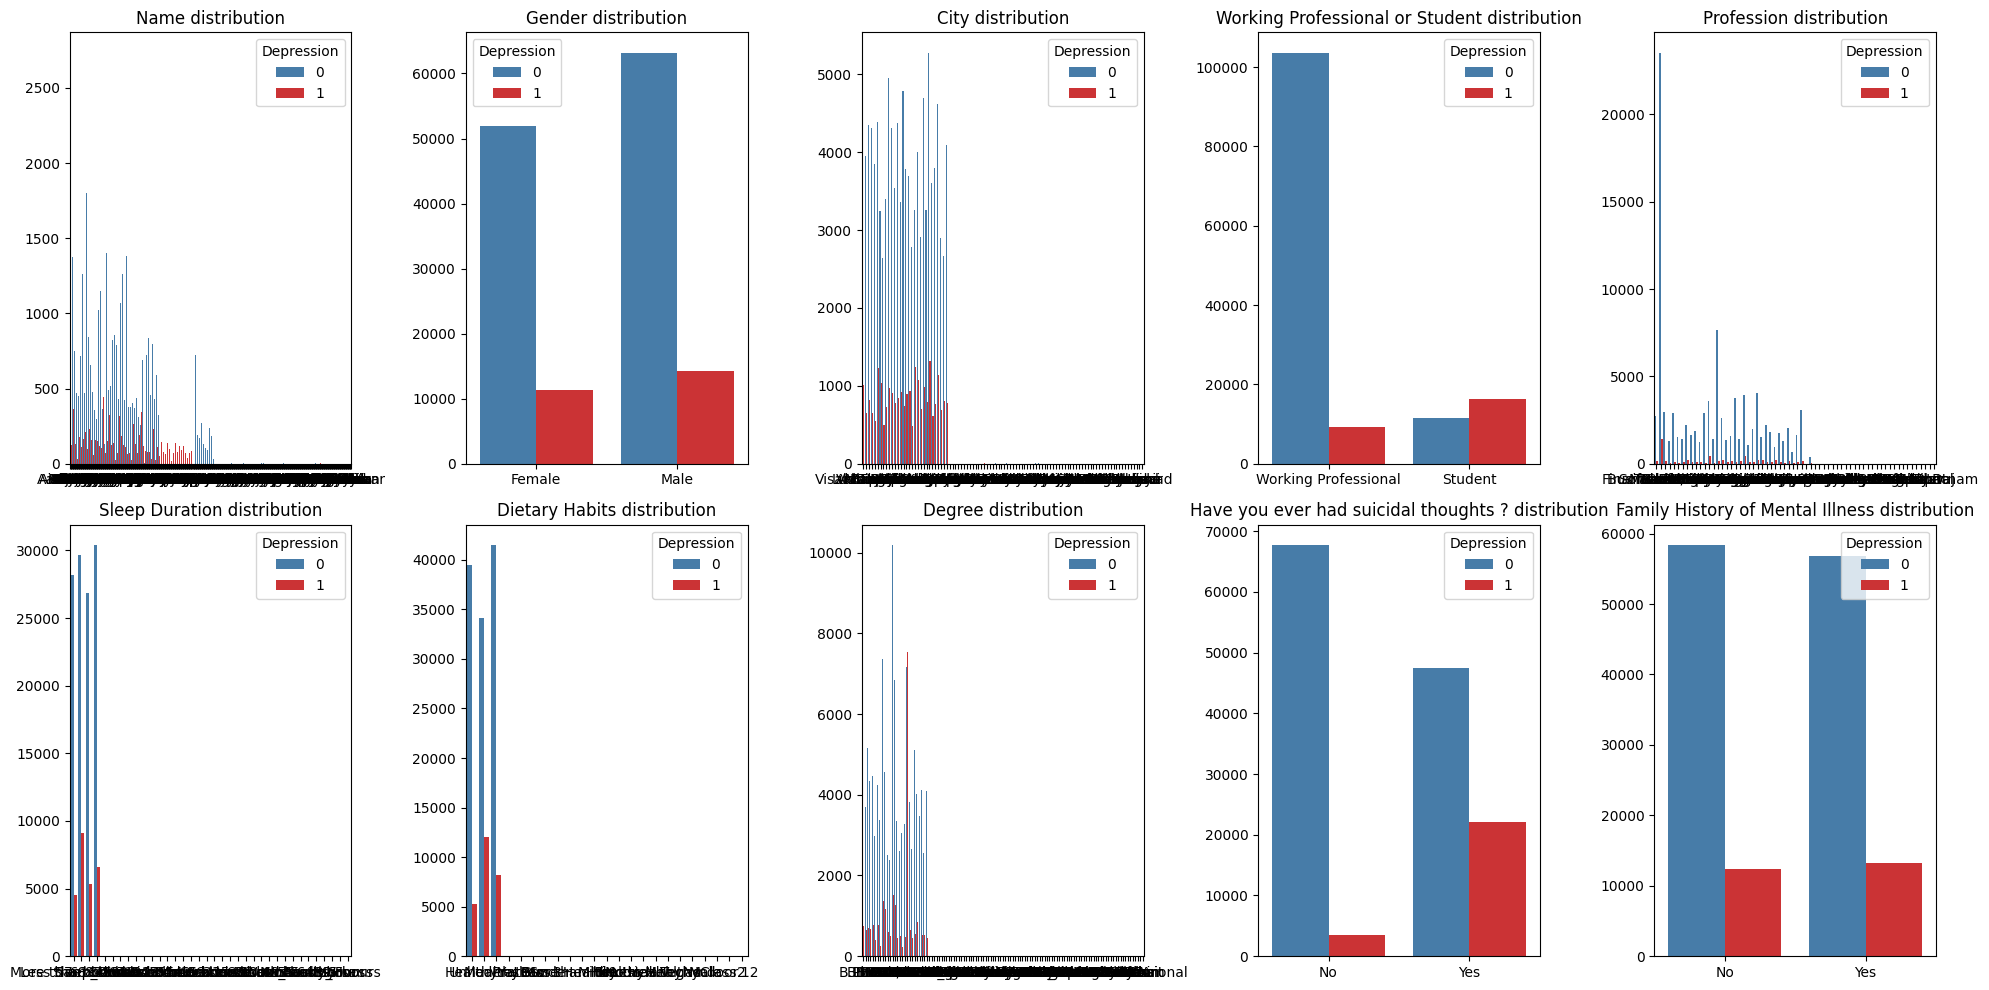

In [5]:
cat_cols = _train.select_dtypes(include='object').columns.tolist()
palette = {0: sns.color_palette("Set1")[1], 1: sns.color_palette("Set1")[0]}

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(data=_train, x=col, hue=CFG.target, ax=axes[i], palette=palette)
    axes[i].set_title(f'{col} distribution')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

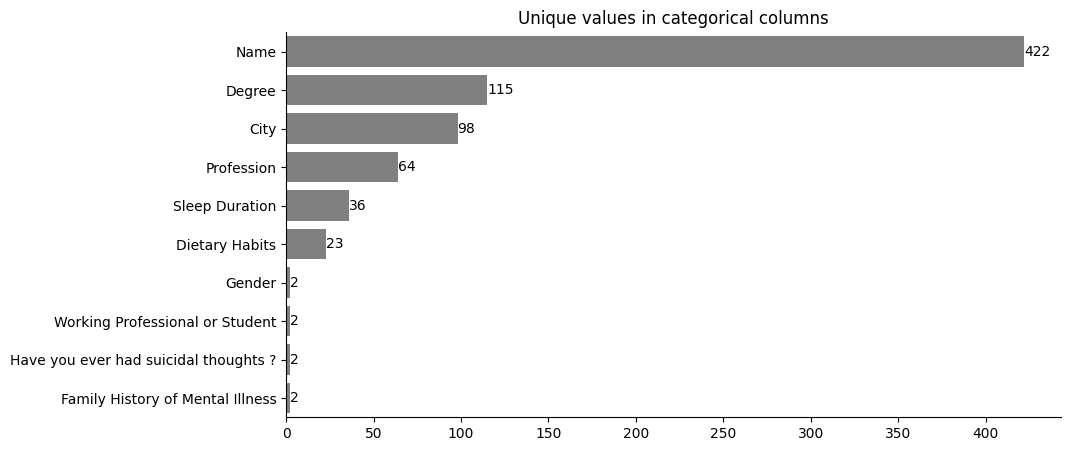

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(
    x=_train[cat_cols].nunique().sort_values(ascending=False).values,
    y=_train[cat_cols].nunique().sort_values(ascending=False).index,
    ax=ax,
    color="grey"
)
ax.set_title('Unique values in categorical columns')

for i, value in enumerate(_train[cat_cols].nunique().sort_values(ascending=False).values):
    ax.text(value, i, f'{value}', va='center')

sns.despine()
plt.show()

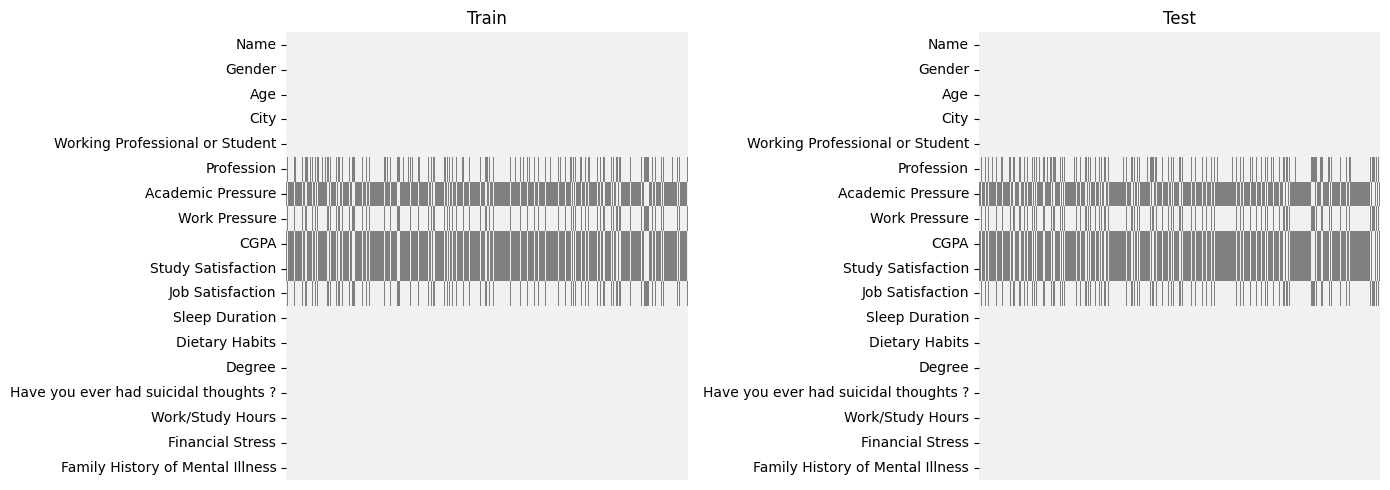

In [7]:
train_null_values = _train.drop(columns=CFG.target).isnull().T
test_null_values = _test.isnull().T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(train_null_values, cbar=False, ax=axes[0], cmap=sns.light_palette('grey', as_cmap=True))
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, ax=axes[1], cmap=sns.light_palette('grey', as_cmap=True))
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

- Below, we'll create a function that:
  1. Converts the categorical columns to the `category` datatype.
  2. Ensures that targets are consistent between the competition and original dataset.
  3. Makes sure the data types are consistent between the original and competition datasets.
  4. Divides both datasets into features and targets to be used by the `Trainer` class later on.

In [8]:
def get_data(model):
    train = pd.read_csv(CFG.train_path, index_col='id')
    test = pd.read_csv(CFG.test_path, index_col='id')
    original = pd.read_csv(CFG.original_data_path)
    original[CFG.target] = original[CFG.target].map({'Yes': 1, 'No': 0})
    
    if model == 'cb':
        cat_cols = test.columns.tolist()
    else:
        cat_cols = test.select_dtypes(include='object').columns.tolist()
        
    train[cat_cols] = train[cat_cols].astype(str).astype('category')
    test[cat_cols] = test[cat_cols].astype(str).astype('category')
    original[cat_cols] = original[cat_cols].astype(str).astype('category')
        
    for col in cat_cols:
        common_categories = train[col].cat.categories.union(original[col].cat.categories)
        train[col] = train[col].cat.set_categories(common_categories)
        original[col] = original[col].cat.set_categories(common_categories)
    
    for col in train.columns:
        original[col] = original[col].astype(train[col].dtype)

    if model in ['gb', 'adb']:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        train[cat_cols] = encoder.fit_transform(train[cat_cols])
        test[cat_cols] = encoder.transform(test[cat_cols])
        original[cat_cols] = encoder.transform(original[cat_cols])
    
        cols_with_missing_values = train.columns[train.isnull().mean() > 0]
        imputer = SimpleImputer(strategy='mean')
        train[cols_with_missing_values] = imputer.fit_transform(train[cols_with_missing_values])
        test[cols_with_missing_values] = imputer.transform(test[cols_with_missing_values])
        original[cols_with_missing_values] = imputer.transform(original[cols_with_missing_values])
    
    X = train.drop(CFG.target, axis=1)
    y = train[CFG.target]
    X_test = test
    
    X_original = original.drop(CFG.target, axis=1)
    y_original = original[CFG.target]
    
    return X, y, X_test, X_original, y_original

# Training base models

In [9]:
class Trainer:
    def __init__(self, model, config=CFG, is_ensemble_model=False):
        self.model = model
        self.config = config
        self.is_ensemble_model = is_ensemble_model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None, threshold=0.5):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            if not self.is_ensemble_model:                                
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble_model:
                coeffs += model.coef_ / self.config.n_folds
                if isinstance(self.model, LogisticRegression):
                    n_iters = model.n_iter_[0]
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[: ,1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = accuracy_score(y_val, (y_pred_probs > threshold).astype(int))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if self.is_ensemble_model and isinstance(self.model, LogisticRegression):
                print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f} ({n_iters} iterations)')
            else:
                print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f}')
            
        overall_score = accuracy_score(y, (oof_pred_probs > threshold).astype(int))
            
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
        if self.is_ensemble_model:
            return oof_pred_probs, test_pred_probs, scores, coeffs
        else:
            os.makedirs('oof_pred_probs', exist_ok=True)
            os.makedirs('test_pred_probs', exist_ok=True)
            self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
            self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
            return oof_pred_probs, test_pred_probs, scores
        
    def fit(self, X, y, threshold=0.5):
        scores = []                
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]  
            score = accuracy_score(y_val, (y_pred_probs > threshold).astype(int))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect() 
        
        return np.mean(scores)
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{name}_pred_probs/{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)

In [10]:
def save_submission(name, test_pred_probs, score, threshold=0.5):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = (test_pred_probs > threshold).astype(int)
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub.head()

In [11]:
lr_params = {
    "C": 5.559884346567435,
    "max_iter": 1000,
    "n_jobs": 4,
    "penalty": "l2",
    "random_state": 42,
    "solver": "newton-cg",
    "tol": 0.08313081991676836
}

cb_params = {
    "border_count": 180,
    "colsample_bylevel": 0.7351678905666684,
    "depth": 4,
    "iterations": 2372,
    "l2_leaf_reg": 4.442847441200204,
    "learning_rate": 0.0514109059943355,
    "min_child_samples": 146,
    "random_state": 42,
    "random_strength": 0.18678416655567043,
    "scale_pos_weight": 1.019889465491297,
    "subsample": 0.3511896501762123,
    "verbose": False
}

xgb_params = {
    "colsample_bylevel": 0.25155109886677396,
    "colsample_bynode": 0.5723191165109757,
    "colsample_bytree": 0.18034301813835885,
    "enable_categorical": True,
    "gamma": 3.6392698070258622,
    "max_bins": 26161,
    "max_depth": 16,
    "max_leaves": 67,
    "min_child_weight": 34,
    "n_estimators": 3853,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 7.996080341061729,
    "reg_lambda": 46.83054555763492,
    "scale_pos_weight": 1.2157646356820928,
    "subsample": 0.9117754083869292,
    "verbosity": 0
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.18283018243382332,
    "learning_rate": 0.09945326391012832,
    "max_bins": 36644,
    "min_child_samples": 105,
    "min_child_weight": 0.2083765599710974,
    "n_estimators": 244,
    "n_jobs": -1,
    "num_leaves": 122,
    "random_state": 42,
    "reg_alpha": 8.662578235164972,
    "reg_lambda": 3.5696291074963926,
    "scale_pos_weight": 1.0733293968870794,
    "subsample": 0.5360642841695424,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.11905309670044416,
    "learning_rate": 0.04641567005485582,
    "max_bins": 18501,
    "min_child_samples": 283,
    "min_child_weight": 0.5242575557671028,
    "n_estimators": 966,
    "n_jobs": -1,
    "num_leaves": 159,
    "random_state": 42,
    "reg_alpha": 8.160196501794122,
    "reg_lambda": 9.861767101758469,
    "scale_pos_weight": 0.991416082619142,
    "subsample": 0.9259030065865966,
    "verbose": -1
}

lgbm_dart_params = {
    "boosting_type": "dart",
    "colsample_bytree": 0.1181378019860333,
    "learning_rate": 0.0910272033595692,
    "max_bins": 7386,
    "min_child_samples": 225,
    "min_child_weight": 0.28492487885169293,
    "n_estimators": 1454,
    "n_jobs": -1,
    "num_leaves": 163,
    "random_state": 42,
    "reg_alpha": 2.9686583338116925,
    "reg_lambda": 9.781841345026509,
    "scale_pos_weight": 0.8309734952725212,
    "subsample": 0.511061530253864,
    "verbose": -1
}

gb_params = {
    'learning_rate': 0.129726178306296,
    'max_depth': 82,
    'max_features': 0.9815414831121304,
    'max_leaf_nodes': 45,
    'min_samples_leaf': 0.0015657248550179637,
    'min_samples_split': 0.3385622260186072,
    'min_weight_fraction_leaf': 0.03201568899384577,
    'n_estimators': 1048,
    'random_state': 42,
    'subsample': 0.9550206349439808
}

adb_params = {
    'learning_rate': 1.5174537517219886,
    'n_estimators': 410,
    'random_state': 42
}

In [12]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e11/discussion/543746

X, y, X_test, X_original, y_original = get_data('lr')
lr_model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', min_frequency=0.001),
    LogisticRegression(**lr_params)
)
lr_trainer = Trainer(lr_model)
oof_pred_probs['LogisticRegression'], test_pred_probs['LogisticRegression'], scores['LogisticRegression'] = lr_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training Pipeline

--- Fold 1 - Accuracy: 0.940689
--- Fold 2 - Accuracy: 0.938024
--- Fold 3 - Accuracy: 0.940370
--- Fold 4 - Accuracy: 0.941222
--- Fold 5 - Accuracy: 0.938806

------ Overall: 0.939822 | Average: 0.939822 ± 0.001206


In [14]:
X, y, X_test, X_original, y_original = get_data("cb")
cb_model = CatBoostClassifier(**cb_params, cat_features=X.columns.tolist())
cb_trainer = Trainer(cb_model)
oof_pred_probs['CatBoost'], test_pred_probs['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training CatBoostClassifier

--- Fold 1 - Accuracy: 0.939908
--- Fold 2 - Accuracy: 0.939090
--- Fold 3 - Accuracy: 0.941187
--- Fold 4 - Accuracy: 0.942075
--- Fold 5 - Accuracy: 0.940121

------ Overall: 0.940476 | Average: 0.940476 ± 0.001042


In [15]:
X, y, X_test, X_original, y_original = get_data("xgb")
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_pred_probs['XGBoost'], test_pred_probs['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training XGBClassifier

--- Fold 1 - Accuracy: 0.939055
--- Fold 2 - Accuracy: 0.936994
--- Fold 3 - Accuracy: 0.940014
--- Fold 4 - Accuracy: 0.941898
--- Fold 5 - Accuracy: 0.939303

------ Overall: 0.939453 | Average: 0.939453 ± 0.001582


In [16]:
X, y, X_test, X_original, y_original = get_data("lgbm")
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs['LightGBM'], test_pred_probs['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - Accuracy: 0.940476
--- Fold 2 - Accuracy: 0.938664
--- Fold 3 - Accuracy: 0.941045
--- Fold 4 - Accuracy: 0.941365
--- Fold 5 - Accuracy: 0.939979

------ Overall: 0.940306 | Average: 0.940306 ± 0.000949


In [17]:
X, y, X_test, X_original, y_original = get_data("lgbm_goss")
lgbm_goss_model = LGBMClassifier(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_pred_probs['LightGBM (goss)'], test_pred_probs['LightGBM (goss)'], scores['LightGBM (goss)'] = lgbm_goss_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - Accuracy: 0.940121
--- Fold 2 - Accuracy: 0.938522
--- Fold 3 - Accuracy: 0.941365
--- Fold 4 - Accuracy: 0.941436
--- Fold 5 - Accuracy: 0.940583

------ Overall: 0.940405 | Average: 0.940405 ± 0.001062


In [18]:
X, y, X_test, X_original, y_original = get_data("lgbm_dart")
lgbm_dart_model = LGBMClassifier(**lgbm_dart_params)
lgbm_dart_trainer = Trainer(lgbm_dart_model)
oof_pred_probs['LightGBM (dart)'], test_pred_probs['LightGBM (dart)'], scores['LightGBM (dart)'] = lgbm_dart_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - Accuracy: 0.938877
--- Fold 2 - Accuracy: 0.938877
--- Fold 3 - Accuracy: 0.940903
--- Fold 4 - Accuracy: 0.941791
--- Fold 5 - Accuracy: 0.939517

------ Overall: 0.939993 | Average: 0.939993 ± 0.001164


In [19]:
X, y, X_test, X_original, y_original = get_data("gb")
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
oof_pred_probs['Gradient Boosting'], test_pred_probs['Gradient Boosting'], scores['Gradient Boosting'] = gb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training GradientBoostingClassifier

--- Fold 1 - Accuracy: 0.939979
--- Fold 2 - Accuracy: 0.938593
--- Fold 3 - Accuracy: 0.941649
--- Fold 4 - Accuracy: 0.942466
--- Fold 5 - Accuracy: 0.940050

------ Overall: 0.940547 | Average: 0.940547 ± 0.001363


In [20]:
X, y, X_test, X_original, y_original = get_data("adb")
adb_model = AdaBoostClassifier(**adb_params)
adb_trainer = Trainer(adb_model)
oof_pred_probs['AdaBoost'], test_pred_probs['AdaBoost'], scores['AdaBoost'] = adb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training AdaBoostClassifier

--- Fold 1 - Accuracy: 0.939837
--- Fold 2 - Accuracy: 0.938415
--- Fold 3 - Accuracy: 0.939588
--- Fold 4 - Accuracy: 0.941222
--- Fold 5 - Accuracy: 0.940334

------ Overall: 0.939879 | Average: 0.939879 ± 0.000921


# L2 Logistic Regression

To ensemble the OOF files of the base models, we will:
1. Tune and train a `LogisticRegression` model.
2. Tune and train a `Ridge` model.
3. Combine the two ensembles using a weighted average.

In [21]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
        else:
            ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [22]:
l2_oof_pred_probs = {}
l2_test_pred_probs = {}

In [23]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [24]:
def objective(trial):
    solver_penalty_options = [
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('lbfgs', 'l2'),
        ('lbfgs', None),
        ('newton-cg', 'l2'),
        ('newton-cg', None),
        ('newton-cholesky', 'l2'),
        ('newton-cholesky', None)
    ]
    solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
    params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'C': trial.suggest_float('C', 0, 10),
        'tol': trial.suggest_float('tol', 1e-10, 1e-1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': solver,
        'penalty': penalty
    }
    
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.001)
    
    model = LogisticRegression(**params)
    trainer = Trainer(model, is_ensemble_model=True)
    return trainer.fit(X, y, threshold)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50, n_jobs=-1)
best_params = study.best_params

[I 2024-12-02 12:36:34,930] A new study created in memory with name: no-name-2f1911e0-f2f5-47e1-acfe-d2022776421d
[I 2024-12-02 12:36:51,042] Trial 0 finished with value: 0.9405046197583511 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 1.5468886310020047, 'tol': 0.09976846834093919, 'fit_intercept': True, 'class_weight': 'balanced', 'threshold': 0.5720000000000001}. Best is trial 0 with value: 0.9405046197583511.
[I 2024-12-02 12:41:40,061] Trial 2 finished with value: 0.9274484719260838 and parameters: {'solver_penalty': ('lbfgs', None), 'C': 2.1101964876330515, 'tol': 0.0729386773009887, 'fit_intercept': True, 'class_weight': 'balanced', 'threshold': 0.5700000000000001}. Best is trial 0 with value: 0.9405046197583511.
[I 2024-12-02 12:42:00,228] Trial 5 finished with value: 0.9266169154228855 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 5.3793263936028515, 'tol': 0.07814019258353436, 'fit_intercept': True, 'class_weight': 'balanced', 'threshold': 0.548}

In [25]:
solver, penalty = best_params['solver_penalty']
lr_params = {
    'random_state': CFG.seed,
    'max_iter': 500,
    'C': best_params['C'],
    'tol': best_params['tol'],
    'fit_intercept': best_params['fit_intercept'],
    'class_weight': best_params['class_weight'],
    'solver': solver,
    'penalty': penalty
}

In [26]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500,
  "C": 2.260096257136456,
  "tol": 0.038571833507851684,
  "fit_intercept": true,
  "class_weight": null,
  "solver": "newton-cholesky",
  "penalty": "l2"
}


In [27]:
best_threshold = study.best_params['threshold']
print(f'Best threshold: {best_threshold:.3f}')

Best threshold: 0.518


In [28]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model, is_ensemble_model=True)
l2_oof_pred_probs['l2-ensemble-lr'], l2_test_pred_probs['l2-ensemble-lr'], scores['L2 Ensemble LR'], lr_coeffs = lr_trainer.fit_predict(X, y, X_test, None, None, best_threshold)

Training LogisticRegression

--- Fold 1 - Accuracy: 0.940334 (4 iterations)
--- Fold 2 - Accuracy: 0.939232 (4 iterations)
--- Fold 3 - Accuracy: 0.941862 (4 iterations)
--- Fold 4 - Accuracy: 0.942217 (4 iterations)
--- Fold 5 - Accuracy: 0.940867 (4 iterations)

------ Overall: 0.940903 | Average: 0.940903 ± 0.001074


In [29]:
save_submission('l2-ensemble-lr', l2_test_pred_probs['l2-ensemble-lr'], np.mean(scores['L2 Ensemble LR']), best_threshold)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


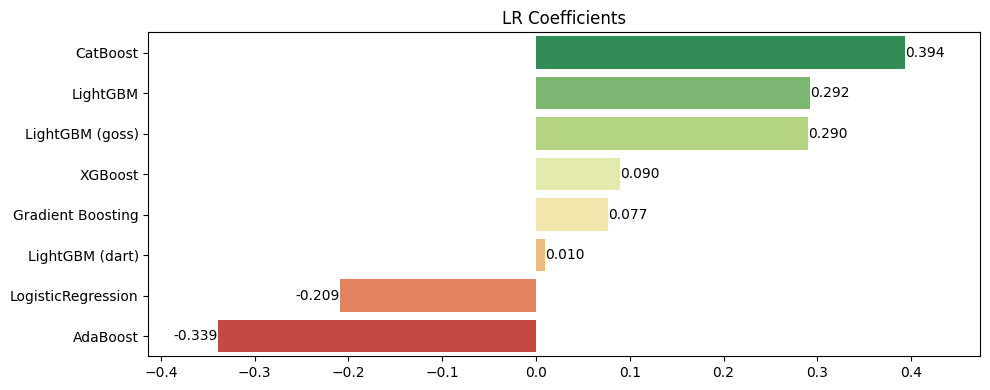

In [30]:
plot_weights(lr_coeffs, 'LR Coefficients')

# L2 Ridge

In [31]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [32]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 50),
        'tol': trial.suggest_float('tol', 1e-10, 1e-2),
        'positive': trial.suggest_categorical('positive', [True, False]),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False])
    }
    
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.001)
    
    model = Ridge(**params)
    trainer = Trainer(model, is_ensemble_model=True)
    return trainer.fit(X, y, threshold)


sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50, n_jobs=-1)
best_params = study.best_params

[I 2024-12-02 13:07:16,475] A new study created in memory with name: no-name-5df4ba8a-b3f0-4a03-98c7-aa47201b9cb8
[I 2024-12-02 13:08:17,246] Trial 1 finished with value: 0.9404264392324093 and parameters: {'alpha': 36.875911521423944, 'tol': 0.006208919484615493, 'positive': True, 'fit_intercept': True, 'threshold': 0.466}. Best is trial 1 with value: 0.9404264392324093.
[I 2024-12-02 13:08:17,936] Trial 3 finished with value: 0.9393105899076047 and parameters: {'alpha': 44.855551164738564, 'tol': 0.003593210587944888, 'positive': True, 'fit_intercept': True, 'threshold': 0.40900000000000003}. Best is trial 1 with value: 0.9404264392324093.
[I 2024-12-02 13:08:20,563] Trial 0 finished with value: 0.9395735607675906 and parameters: {'alpha': 22.790969608022436, 'tol': 0.007710455982192996, 'positive': True, 'fit_intercept': False, 'threshold': 0.41700000000000004}. Best is trial 1 with value: 0.9404264392324093.
[I 2024-12-02 13:08:24,954] Trial 2 finished with value: 0.940063965884861

In [33]:
ridge_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol'],
    'positive': best_params['positive'],
    'fit_intercept': best_params['fit_intercept']
}

In [34]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 10.568709303516307,
  "tol": 0.007362718162043494,
  "positive": false,
  "fit_intercept": false
}


In [35]:
best_threshold = study.best_params['threshold']
print(f'Best threshold: {best_threshold:.3f}')

Best threshold: 0.503


In [36]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model, is_ensemble_model=True)
l2_oof_pred_probs['l2-ensemble-ridge'], l2_test_pred_probs['l2-ensemble-ridge'], scores['L2 Ensemble Ridge'], ridge_coeffs = ridge_trainer.fit_predict(X, y, X_test, None, None, best_threshold)

Training Ridge

--- Fold 1 - Accuracy: 0.940654
--- Fold 2 - Accuracy: 0.939161
--- Fold 3 - Accuracy: 0.941827
--- Fold 4 - Accuracy: 0.941827
--- Fold 5 - Accuracy: 0.940903

------ Overall: 0.940874 | Average: 0.940874 ± 0.000980


In [37]:
save_submission('l2-ensemble-ridge', l2_test_pred_probs['l2-ensemble-ridge'], np.mean(scores['L2 Ensemble Ridge']), best_threshold)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


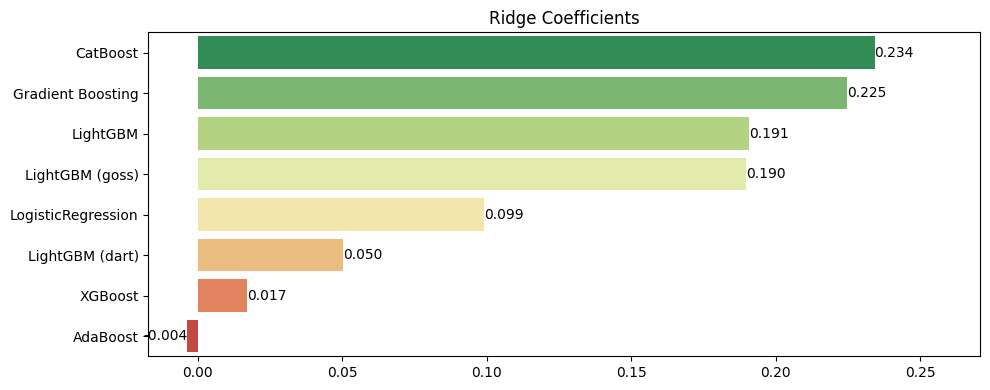

In [38]:
plot_weights(ridge_coeffs, 'Ridge Coefficients')

# L3 Weighted ensemble

In [39]:
def objective(trial):
    weights = np.array([trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_pred_probs.keys()])
    weights /= np.sum(weights)
    
    preds = np.zeros(len(y))
    for model, weight in zip(l2_oof_pred_probs.keys(), weights):
        preds += l2_oof_pred_probs[model] * weight
        
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.001)
            
    return accuracy_score(y, (preds > threshold).astype(int))

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-12-02 13:14:19,137] A new study created in memory with name: no-name-a85e6842-bb9e-4a8c-8fca-370696cf968b
[I 2024-12-02 13:14:19,189] Trial 0 finished with value: 0.9408670931058991 and parameters: {'l2-ensemble-lr': 0.8599985246388516, 'l2-ensemble-ridge': 0.9378744391637964, 'threshold': 0.508}. Best is trial 0 with value: 0.9408670931058991.
[I 2024-12-02 13:14:19,207] Trial 2 finished with value: 0.9408031272210376 and parameters: {'l2-ensemble-lr': 0.27312607361078733, 'l2-ensemble-ridge': 0.9367665722636699, 'threshold': 0.516}. Best is trial 0 with value: 0.9408670931058991.
[I 2024-12-02 13:14:19,210] Trial 1 finished with value: 0.9394740582800284 and parameters: {'l2-ensemble-lr': 0.5234021292623314, 'l2-ensemble-ridge': 0.25595660812971277, 'threshold': 0.6}. Best is trial 0 with value: 0.9408670931058991.
[I 2024-12-02 13:14:19,229] Trial 3 finished with value: 0.9403909026297086 and parameters: {'l2-ensemble-lr': 0.23577527427952605, 'l2-ensemble-ridge': 0.95554539

In [40]:
scores['L3 Weighted Ensemble (LR + Ridge)'] = [study.best_value] * CFG.n_folds

In [41]:
best_weights = np.array([study.best_params[l2_model] for l2_model in l2_oof_pred_probs.keys()])
best_weights /= np.sum(best_weights)
print(json.dumps({model: weight for model, weight in zip(l2_oof_pred_probs.keys(), best_weights)}, indent=2))

best_threshold = study.best_params['threshold']
print(f'\nBest threshold: {best_threshold:.3f}')

{
  "l2-ensemble-lr": 0.5593926663024852,
  "l2-ensemble-ridge": 0.4406073336975147
}

Best threshold: 0.502


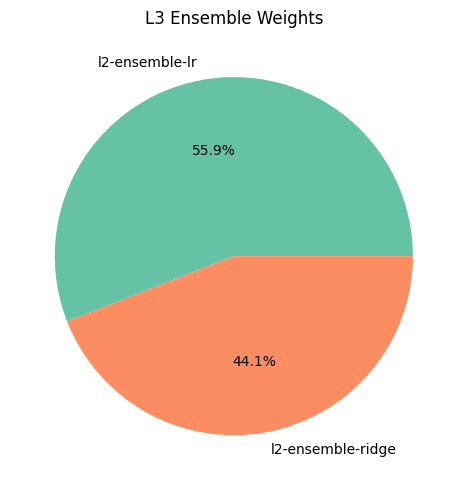

In [42]:
plt.figure(figsize=(8, 5))
plt.pie(
    [v for k,v in study.best_params.items() if k != "threshold"], 
    labels=[k for k,v in study.best_params.items() if k != "threshold"], 
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2', 2)
)
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()

In [43]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_pred_probs.keys(), best_weights):
    weighted_test_preds += l2_test_pred_probs[model] * weight
    
save_submission('l3-weighted-ensemble', weighted_test_preds, np.mean(scores['L3 Weighted Ensemble (LR + Ridge)']), best_threshold)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


# Results

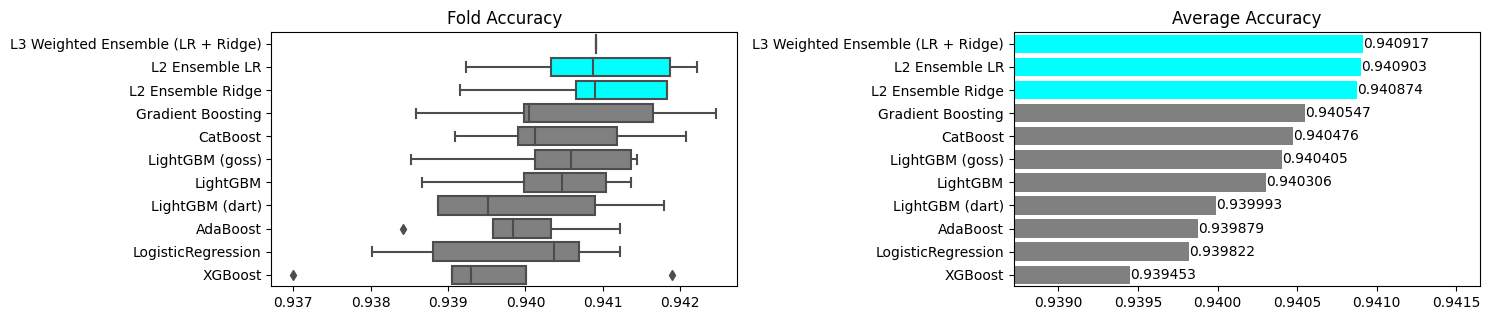

In [44]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='grey')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='grey')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = 'cyan' if 'ensemble' in model.lower() else 'grey'
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [45]:
shutil.rmtree('catboost_info', ignore_errors=True)